<a href="https://colab.research.google.com/github/snigdha2606/SE20UARI146_Assignment3_Q2/blob/main/cats%26dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"snigdhaasthana","key":"44a3f9f57f4fd1ab3ba8b75eff423af6"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d tongpython/cat-and-dog --force

 99% 216M/218M [00:10<00:00, 25.7MB/s]
100% 218M/218M [00:10<00:00, 21.2MB/s]


In [3]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [5]:
train_dir = os.path.join('training_set', 'training_set')
test_dir = os.path.join('test_set', 'test_set')

trainloader = image_dataset_from_directory(train_dir, labels='inferred', batch_size=32, image_size=(224,224), shuffle=True, seed=42)
testloader = image_dataset_from_directory(test_dir, labels='inferred', batch_size=32, image_size=(224,224), shuffle=True, seed=42)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(testloader)
valloader = testloader.take(val_batches//5)
testloader = testloader.skip(val_batches//5)

In [7]:
class_names = trainloader.class_names
print(class_names)

['cats', 'dogs']


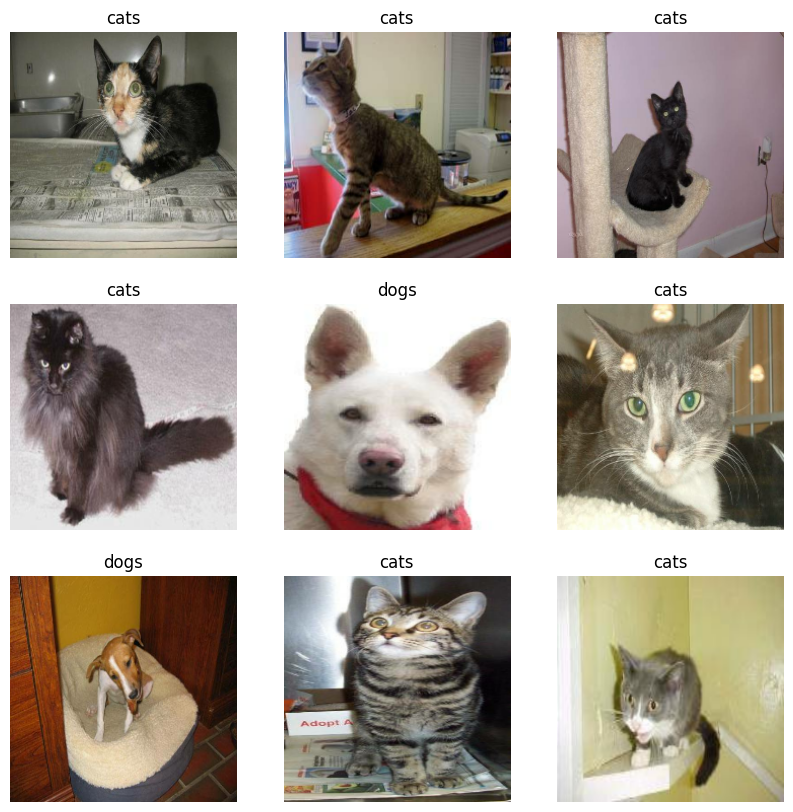

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in trainloader.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
resnet = ResNet50(input_shape=(224,224,3),
                  include_top = False,
                  weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [10]:
resnet.trainable=False

In [11]:
image_batch, label_batch = next(iter(trainloader))
feature_batch = resnet(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 2048)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(224,224,3)))
model.add(resnet)
model.add(global_average_layer)
model.add(tf.keras.layers.Dropout(0.2))
model.add(prediction_layer)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


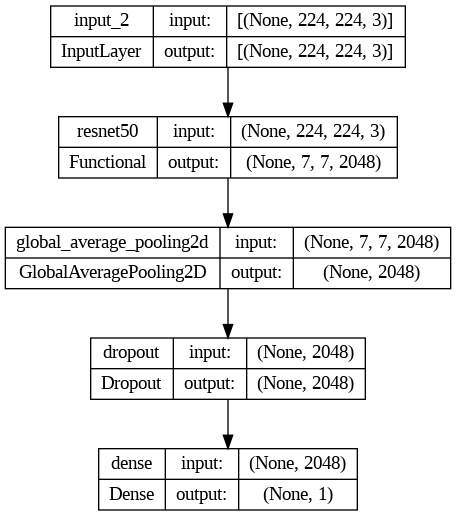

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [18]:
initial_epochs = 15
loss0, accuracy0 = model.evaluate(valloader)
print("initial loss: ", loss0)
print("initial accuracy: ", accuracy0)

12/12 [==============================] - 3s 106ms/step - loss: 0.9043 - accuracy: 0.4922
initial loss:  0.9042735695838928
initial accuracy:  0.4921875


In [19]:
hist = model.fit(trainloader,
                 epochs = initial_epochs,
                 validation_data = valloader)

Epoch 1/15
251/251 [==============================] - 32s 108ms/step - loss: 0.1215 - accuracy: 0.9518 - val_loss: 0.0568 - val_accuracy: 0.9766
Epoch 2/15
251/251 [==============================] - 27s 107ms/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 0.0511 - val_accuracy: 0.9792
Epoch 3/15
251/251 [==============================] - 29s 113ms/step - loss: 0.0476 - accuracy: 0.9803 - val_loss: 0.0456 - val_accuracy: 0.9792
Epoch 4/15
251/251 [==============================] - 27s 108ms/step - loss: 0.0422 - accuracy: 0.9836 - val_loss: 0.0767 - val_accuracy: 0.9714
Epoch 5/15
251/251 [==============================] - 27s 107ms/step - loss: 0.0395 - accuracy: 0.9838 - val_loss: 0.0506 - val_accuracy: 0.9740
Epoch 6/15
251/251 [==============================] - 27s 108ms/step - loss: 0.0377 - accuracy: 0.9854 - val_loss: 0.0581 - val_accuracy: 0.9766
Epoch 7/15
251/251 [==============================] - 27s 108ms/step - loss: 0.0353 - accuracy: 0.9846 - val_loss: 0.0502 - val_ac

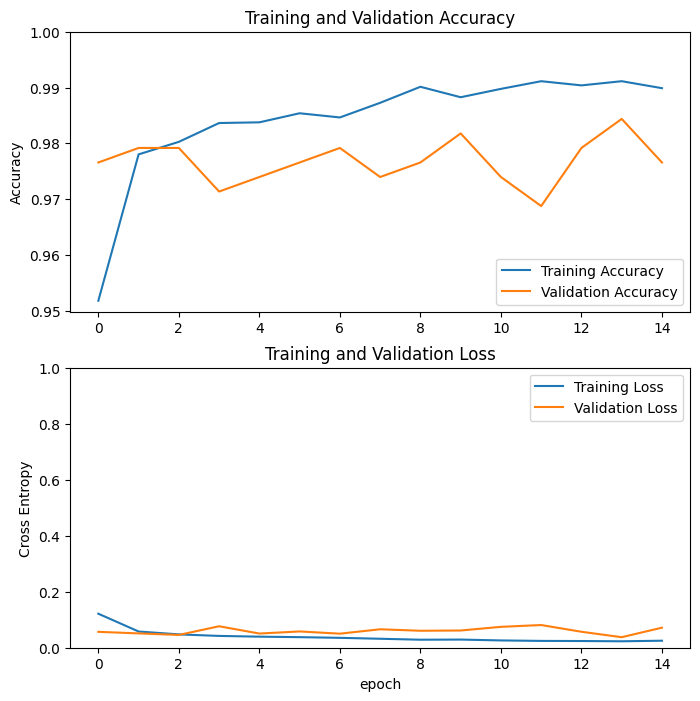

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
accuracy = Accuracy()

for x,y in testloader:
  prediction = model.predict(x).flatten()
  prediction = tf.nn.sigmoid(prediction)
  prediction = tf.where(prediction < 0.5, 0, 1)
  accuracy.update_state(y, prediction)

accuracy = accuracy.result()

1/1 [==============================] - 2s 2s/step


In [22]:
print("Testing Accuracy: " ,accuracy.numpy())

Testing Accuracy:  0.9755949


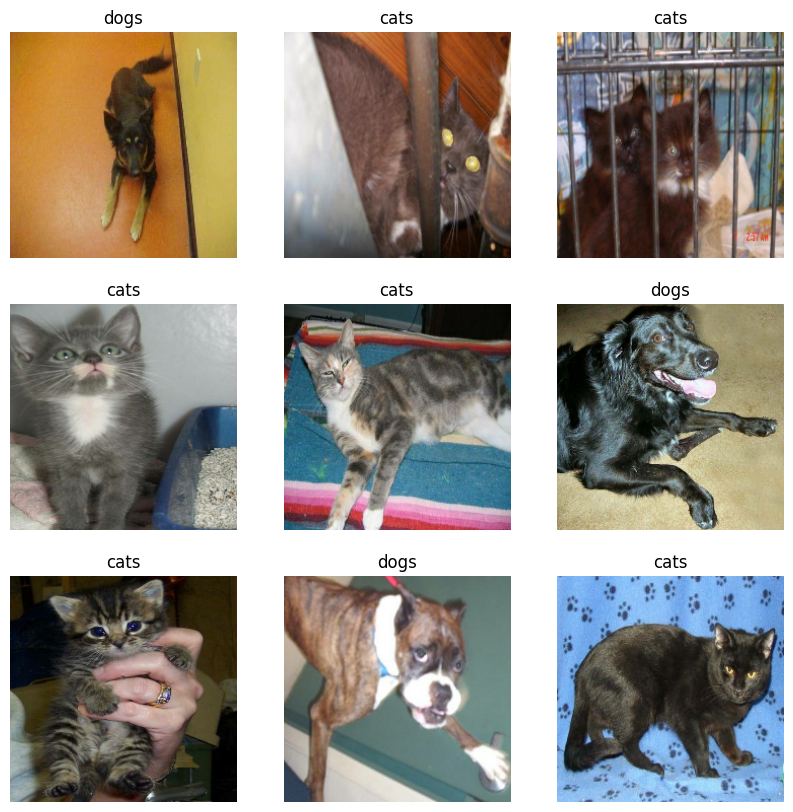

In [23]:
image_batch, label_batch = testloader.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

label_batch = ["cats" if i==0 else "dogs" for i in label_batch]
pred_labels = ["cats" if i==0 else "dogs" for i in predictions]

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")